# Exploratory data analysis with labeled data
Now that we have the labels for our data, we can do some initial EDA to see if there is something different between the hackers and the valid users.

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import sqlite3

with sqlite3.connect('logs/logs.db') as conn:
    logs_2018 = pd.read_sql(
        'SELECT * FROM logs WHERE datetime BETWEEN "2018-01-01" AND "2019-01-01";', 
        conn, parse_dates=['datetime'], index_col='datetime'
    )
    hackers_2018 = pd.read_sql(
        'SELECT * FROM attacks WHERE start BETWEEN "2018-01-01" AND "2019-01-01";', 
        conn, parse_dates=['start', 'end']
    ).assign(
        duration=lambda x: x.end - x.start, 
        start_floor=lambda x: x.start.dt.floor('min'),
        end_ceil=lambda x: x.end.dt.ceil('min')
    )
hackers_2018.head()

,start,end,source_ip,duration,start_floor,end_ceil
0,2018-01-05 06:03:42.470259,2018-01-05 06:03:51.470259,170.9.4.108,00:00:09,2018-01-05 06:03:00,2018-01-05 06:04:00
1,2018-01-11 03:08:43.284085,2018-01-11 03:09:14.284085,27.255.30.3,00:00:31,2018-01-11 03:08:00,2018-01-11 03:10:00
2,2018-01-17 00:41:43.985324,2018-01-17 00:45:56.985324,226.98.192.152,00:04:13,2018-01-17 00:41:00,2018-01-17 00:46:00
3,2018-01-21 10:34:57.842776,2018-01-21 10:38:01.842776,102.178.107.171,00:03:04,2018-01-21 10:34:00,2018-01-21 10:39:00
4,2018-01-21 23:12:10.852725,2018-01-21 23:12:38.852725,48.172.61.152,00:00:28,2018-01-21 23:12:00,2018-01-21 23:13:00


In [3]:
def check_if_hacker(datetimes, hackers, resolution='1min'):
    date_ranges = hackers.apply(
        lambda x: pd.date_range(x.start_floor, x.end_ceil, freq=resolution), 
        axis=1
    )
    dates = pd.Series()
    for date_range in date_ranges:
        dates = pd.concat([dates, date_range.to_series()])
    return datetimes.isin(dates)

In [4]:
users_with_failures = logs_2018['2018-Q1'].assign(
    failures=lambda x:  1 - x.success
).query('failures > 0').resample('1min').agg(
    {'username':'nunique', 'failures': 'sum'}
).dropna().rename(
    columns={'username':'usernames_with_failures'}
)
labels = check_if_hacker(users_with_failures.reset_index().datetime, hackers_2018)
users_with_failures['flag'] = labels[:users_with_failures.shape[0]].values
users_with_failures.head()

,usernames_with_failures,failures,flag
datetime,,,
2018-01-01 16:01:00,1,1,False
2018-01-01 16:02:00,0,0,False
2018-01-01 16:03:00,0,0,False
2018-01-01 16:04:00,0,0,False
2018-01-01 16:05:00,0,0,False


Text(0.5, 0.98, 'Usernames with failures on minute resolution')

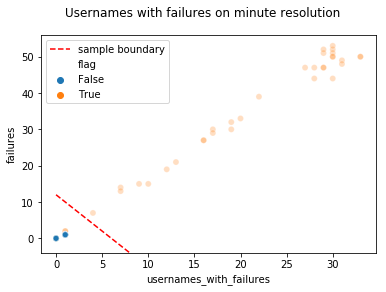

In [5]:
ax = sns.scatterplot(
    x=users_with_failures.usernames_with_failures, 
    y=users_with_failures.failures, alpha=0.25,
    hue=users_with_failures.flag
)
ax.plot([0, 8], [12, -4], 'r--', label='sample boundary')
plt.ylim(-4, None)
plt.legend()
plt.suptitle('Usernames with failures on minute resolution')